<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2023notebooks/2020_0720tlpa_sala_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCAP Project TLPA and SALA combined

- title: 転移学習による TLPA 画像認識
- author: 浅川伸一
- filename: `2020-0712tlpa_resnet18.ipynb`
- last date: 2020-0713
- note:
    - 使用モデル: ResNet-18, 論文: https://arxiv.org/abs/1512.03385
    - データ: TLPA 図版 大門正太郎 先生より
    
## 手順

1. データを定義する。PyTorch の場合 dataloader を使うために DataSet の定義を必要とする
2. モデルを定義する。転移学習の場合，訓練済モデルが公開されているので，そのモデルを使う。
    どのモデルを使ってもよいのだが，`model = models.vgg16(weights="DEFAULT", progress=True)` のようなモデルを使う
3. 最終層を，解くべき問題のクラス数に合わせて付け替える
4. 損失関数を定義する
5. 最適化関数を定義する
6. 訓練を実行する
7. 評価する

という流れになる

In [1]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#import sys
from termcolor import colored
#  print(colored('Miss', 'red'), end="")

In [ ]:
# 各画像の画面表示時に日本語キャプションを付与する準備
import matplotlib.pyplot as plt
%matplotlib inline
!pip install japanize-matplotlib
import japanize_matplotlib

#  ImageNet の各ラベルの WordNet ID 処理用
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

#ライブラリのインストール
!git clone https://github.com/project-ccap/ccap.git

#付属のデータをダウンロードする
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xKXbovkEQwdJefzCuaS_a351LUIuRz-1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xKXbovkEQwdJefzCuaS_a351LUIuRz-1" -O ccap_data.tgz && rm -rf /tmp/cookies.txt
!tar xzf ccap_data.tgz


## 1. データの定義

全データ all_data にたいして以下の辞書を定義:

- num2id: 全データ番号 (num) と ラベル名の数字である ID 番号との関係
- num2owrd: 全データ番号 (num) からラベル名 word を検索する辞書
- id2word: ID 番号から ラベル名 (目標語 word) から検索する辞書
- word2id: ラベル名 (目標語 word) から付番した ID 番号を検索する辞書

id 番号と num 番号ともに数字であるが， id < num である。
num は全データに対してユニークに付番されている。
一方 id は label に対応している。
すなわち総単語数，あるいは総語彙数である。

In [5]:
def combine_tlpa_sala():
    from ccap import tlpaDataset
    from ccap import salaDataset

    tlpa = tlpaDataset()
    sala = salaDataset()

    #print(sala.data[34])
    #print(sala.labels[34])
    sala.data[34]['label'] = 'すりこ木'
    sala.labels[34] = 'すりこ木'

    tlpa_set = set(tlpa.labels)
    sala_set = set(sala.labels)

    # TLPA の単語から連番を得るための辞書
    tlpa_word2num = {tlpa.data[x]['label']:x for x in tlpa.data}

    # SALA の単語から連番を得るための辞書
    sala_word2num = {sala.data[x]['label']:x for x in sala.data}

    # TLPA と SALA  で重複する単語を探す
    dup_words = []
    counter = 0
    for i, word in enumerate(tlpa.labels):
        if word in sala_set:
            counter += 1
            dup_words.append(word)

    print('There are ', colored(len(dup_words), 'red'), 'duplicate images.')

    # TLPA と SALA とで共通するデータベース all_data の作成
    num = 0
    img_file_list = []
    ## 最初は TLPA
    num2word = {}
    for word in tlpa.labels:
        num2word[num] = word
        img_file_list.append(tlpa.data[num]['img'])
        num +=1

    ##  続いて SALA ,  num はリセットしない
    for j, word in enumerate(sala.labels):
        num2word[num] = word
        img_file_list.append(sala(j)[0])
        num += 1

    word2id, _id = {}, 0
    for num in num2word:
        word = num2word[num]
        if not word in word2id:
            word2id[word] = _id
            _id += 1

    id2word = {_id:word for word, _id in word2id.items()}
    num2id = {num:word2id[num2word[num]] for num in num2word}

    print(dup_words)
    print('TLPA words:', tlpa.__len__())
    print('SALA words:', sala.__len__())
    print('Duplicated words:', len(dup_words))
    print('Number of data :', tlpa.__len__() + sala.__len__())
    out_features = tlpa.__len__() + sala.__len__() - len(dup_words)
    print('Number of labels:', out_features)
    print('## 上の数が出力層のニューロン数になる')

    #print(img_file_list)
    #print(num2id)
    #print(out_features)
    return img_file_list, num2id, num2word, id2word, out_features, dup_words

In [ ]:
_img_file_list, _num2id, _num2word, _id2word, _out_features, _dup_words = combine_tlpa_sala()
#print(_img_list)
#print(_num2id)
#print(_dup_words)
#print(_out_features)

In [ ]:
# # from https://github.com/dmlc/xgboost/issues/1715
# # ただし，https://software.intel.com/en-us/comment/1579647 によれば，Intel CPU の問題
# import os
# import platform

# if platform.system() == 'Darwin':
#     if os.environ.__contains__('KMP_DUPLICATE_LIB_OK') == False or os.environ['KMP_DUPLICATE_LIB_OK'] == 'False':
#         os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
%matplotlib inline
import sys
import numpy as np
import json
import random
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import japanize_matplotlib

import skimage.color  # for gray2rgb()
from scipy.special import logsumexp, softmax
import importlib  # for debugging
from termcolor import colored

#import torch
import torchvision
from torchvision import models, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

# PyTorch バージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1
Torchvision Version:  0.15.2a0


## 2.  モデルの定義

In [ ]:
# 各モデルを定義し，訓練済み結合係数をダウンロードする
DNNs = {}
DNNs['resnet18'] = models.resnet18(weights="DEFAULT", progress=True)
# DNNs['alexnet'] = models.alexnet(weights="DEFAULT", progress=True)
# DNNs['vgg16'] = models.vgg16(weights="DEFAULT", progress=True)
# DNNs['squeezenet']= models.squeezenet1_0(weights="DEFAULT", progress=True)
# DNNs['densenet'] = models.densenet161(weights="DEFAULT", progress=True)
# DNNs['inception'] = models.inception_v3(weights="DEFAULT", progress=True)
# DNNs['googlenet'] = models.googlenet(weights="DEFAULT", progress=True)
# DNNs['shufflenet'] = models.shufflenet_v2_x1_0(weights="DEFAULT", progress=True)
# DNNs['mobilenet'] = models.mobilenet_v2(weights="DEFAULT", progress=True)
# DNNs['resnext50_32x4d'] = models.resnext50_32x4d(weights="DEFAULT", progress=True)
# DNNs['wide_resnet50_2'] = models.wide_resnet50_2(weights="DEFAULT", progress=True)
# DNNs['mnasnet'] = models.mnasnet1_0(weights="DEFAULT", progress=True)

In [ ]:
# 上の中から試したいモデルを選んでください。最後のモデルが有効になります。
net = DNNs['resnet18']
#net = DNNs['squeezenet']
#net = DNNs['googlenet']
#net = DNNs['shufflenet']
#net = DNNs['mobilenet']
#net = DNNs['vgg16']
#net = DNNs['alexnet']

In [ ]:
a_parameters = {name:param for name, param in net.named_parameters()}
a_modules = {name:param for name, param in net.named_modules()}

In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

# RGB 各チャンネルの平均と分散の定義。CNN 唯一の前処理
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=mean, std=std)
#mean = torch.mean(torch.tensor(means))
#std = torch.mean(torch.tensor(stds))

In [ ]:
# 乱数のシードを設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる
class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時は RandomResizedCrop と RandomHorizontalFlip で データ拡張

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize,
                    scale=(0.95, 1.0)),              # データ拡張
                    #scale=(0.8, 1.0)),              # データ拡張
                transforms.RandomHorizontalFlip(),  # データ拡張
                transforms.RandomAffine(
                    degrees=(-5,5),
                    #degrees=(-20,20),
                    translate=None,
                    #scale=[0.9,1.1]
                ),
                transforms.ToTensor(),          # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),      # リサイズ
                transforms.CenterCrop(resize),  # 画像中央を resize×resize で切り取り
                transforms.ToTensor(),          # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [ ]:
#help(transforms.RandomAffine)

## 3. PyTorch 用の DataSet の定義

In [ ]:
# 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# Dataset の作成
class tlpa_sala_torch_Dataset(data.Dataset):
    """
    TLPA 画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, name_dict, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定
        self.namedict = name_dict

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = PILImage.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        label = self.namedict[index]
        return img_transformed, label


train_dataset = tlpa_sala_torch_Dataset(file_list= _img_file_list,
                                        name_dict = _num2id,
                                        transform = ImageTransform(size, mean, std),
                                        phase='train')

val_dataset = tlpa_sala_torch_Dataset(file_list= _img_file_list,
                                      name_dict = _num2id,
                                      transform = ImageTransform(size, mean, std),
                                      phase='val')

# 動作確認
index = 3
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(train_dataset.__len__())

torch.Size([3, 224, 224])
3
366


In [ ]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {
    "train": train_dataloader,
    "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([64, 3, 224, 224])
tensor([ 70, 292,  21, 264, 321, 158, 274, 129, 183, 276, 165, 271, 188, 304,
        185, 182, 234,  49,   5,  60, 154,  37,  39, 114, 164, 112, 330, 142,
        305, 103,  69, 215, 206, 228, 319, 213, 119, 122, 173, 262, 212, 180,
        244, 172, 273, 141, 159, 242,  38,  88,  92, 124, 151, 191, 238,   0,
        190, 122,   0, 316,  77, 205, 311, 187])


In [ ]:
# モデルのインスタンスを生成し，事前学習済の結合係数をロード
#use_pretrained = True  # 学習済みのパラメータを使用
#net = models.resnet18(pretrained=use_pretrained)
net.fc

Linear(in_features=512, out_features=1000, bias=True)

## 6. 転移学習のための最終層の付け替え

In [ ]:
# モデルの最終直下層の出力ユニット数を TLPA+SALA に合わせて 366 にする
net.fc = nn.Linear(in_features=512, out_features=_out_features)

# 訓練モードに設定
net.train();

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4.  損失関数の定義

In [ ]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [ ]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["fc.weight", "fc.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

fc.weight
fc.bias
-----------
[Parameter containing:
tensor([[ 1.0305e-02,  1.6043e-02,  3.4995e-02,  ..., -2.9854e-02,
         -2.3399e-02,  4.3689e-02],
        [-7.3962e-03,  1.5481e-02,  3.0563e-02,  ...,  2.3592e-02,
         -4.8327e-04, -3.1155e-02],
        [-1.1709e-02, -1.4309e-02,  2.7294e-02,  ..., -3.3432e-02,
         -3.8672e-02, -4.8822e-05],
        ...,
        [-2.1964e-02, -1.0156e-02,  1.7074e-02,  ...,  4.0942e-03,
         -6.2160e-03, -2.2499e-02],
        [ 1.0727e-02, -2.2909e-02,  4.0012e-02,  ..., -4.1696e-02,
         -3.5436e-02, -3.4713e-02],
        [-3.5402e-02, -2.8541e-02,  4.2760e-02,  ..., -2.1065e-03,
          4.3618e-02,  4.2062e-02]], requires_grad=True), Parameter containing:
tensor([ 3.1791e-02,  1.5246e-02,  4.3827e-02,  6.4046e-03,  4.3962e-02,
         1.9118e-02, -1.9059e-02, -1.3929e-03, -4.5361e-03,  2.7386e-02,
        -3.1369e-03, -1.8096e-02, -1.2658e-02, -1.0902e-02, -4.4703e-03,
        -3.2239e-02, -7.7291e-03, -2.1618e-02,  7.187

## 5. 最適化関数の定義

In [ ]:
# 最適化手法の設定
#optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
#help(optim.Adam)
#optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params=params_to_update)

In [ ]:
# モデルを学習させる関数
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モード
            else:
                net.eval()   # モデルを検証モード

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            #for inputs, labels in tqdm(dataloaders_dict[phase]):
            # tqdm は要らん。冗長な出力になるだけ
            for inputs, labels in dataloaders_dict[phase]:
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [ ]:
for inputs, labels in dataloaders_dict['train']:
    print(inputs.size(), labels)
    output = net(inputs)
    loss = criterion(output, labels)

torch.Size([64, 3, 224, 224]) tensor([267, 153, 138, 279,  40, 303, 167,  21, 327, 108, 219, 326,  19, 171,
         56, 325, 123, 268, 241, 254, 130, 169, 304, 255,  84, 257, 107, 224,
         62, 188, 271, 152,  55,  90, 313,  93,  33,  60,  34, 318, 193, 177,
        277, 189,  12,  65,  85, 141, 308, 250,  53,  16,  37, 155,   7, 172,
        154,  91,  77, 236, 196, 113, 119, 176])
torch.Size([64, 3, 224, 224]) tensor([265, 214, 158, 305,  12,  13,  95, 143, 150, 310,  11, 201, 209, 164,
         97,  49, 197, 192, 174, 144, 299, 330, 306, 281,   3, 256,  54, 132,
        165, 324, 136, 282, 148, 128,  53,  36, 294, 225, 202,  50, 280,  61,
        230, 203,  28, 207, 112, 253, 115,  83, 246,  59, 125, 264, 321, 171,
         82, 323, 300, 114, 139, 248, 163, 126])
torch.Size([64, 3, 224, 224]) tensor([  8,  96, 227, 272,  66,  79,  25, 200,  72, 137,  92, 311,  39,  76,
          7, 261, 249, 316,  35, 295, 184, 140, 273,   1, 317, 208,  52,  42,
        126, 156, 199,   5, 102,

In [ ]:
# 保存してある訓練済モデルを読み込む
import os
HOME = os.environ['HOME']
base = os.path.join(HOME, 'study/2020ccap/notebooks')
saved_weight_file = os.path.join(base,'2020-0722tlpa_sala_resnet18_weights.pth')
load_weights = torch.load(saved_weight_file)
net.load_state_dict(load_weights)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
%%time
# 学習・検証を実行する
num_epochs=3
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
#saved_weight_file = '2020-0722tlpa_sala_resnet18_weights-2.pth'
saved_weight_file = '2023_0718tlpa_sala_resnet18_weights.pth'
torch.save(net.state_dict(), saved_weight_file)
load_weights = torch.load(saved_weight_file)
net.load_state_dict(load_weights)

In [ ]:
#saved_weight_file = '2020-0722tlpa_sala_resnet18_weights-2.pth'
#torch.save(net.state_dict(), saved_weight_file)
load_weights = torch.load(saved_weight_file)
net.load_state_dict(load_weights)

  0 Hit [  0 119  91 145  90] バス いちょう サイ タイヤキ ピラミッド [0.057 0.037 0.033 0.026 0.024]
  1 Hit [  1 105 109  98  38] 桜 梅 ぶどう 三輪車 犬 [0.061 0.040 0.039 0.039 0.038]
  2 Hit [  2  27 137 306 259] のり巻き 信号 落花生 手紙 箱 [0.062 0.056 0.038 0.033 0.032]
  3 Hit [  3  14  52 234  64] 五重塔 縁側 人参 教会 藤 [0.054 0.044 0.037 0.035 0.035]
  4 Hit [  4   7 255 129 173] コップ 風呂 茶筒 口 へそ [0.036 0.035 0.028 0.027 0.025]
  5 Hit [  5 101  50  65  52] ごぼう アスパラガス 階段 ピンセット 人参 [0.145 0.093 0.047 0.038 0.032]
  6 Hit [  6  91 160  74 151] 土踏まず サイ かかと 鳩 山羊 [0.039 0.034 0.032 0.022 0.021]
  7 Hit [  7 102 136 128 170] 風呂 ドア 二階 手すり 便所 [0.035 0.035 0.031 0.029 0.028]
  8 Hit [  8  19 131   1 179] ヒトデ 鍵 風車 桜 もみじ [0.071 0.049 0.036 0.028 0.026]
  9 Hit [  9  48  35 138 185] ハム 豆腐 みかん 御飯 枕 [0.098 0.040 0.033 0.032 0.030]
 10 Hit [ 10  91 172 119  26] 兎 サイ 猫 いちょう ちまき [0.053 0.053 0.042 0.040 0.035]
 11 Hit [ 11  95 147   7 103] ロープウエイ 刺身 靴べら 風呂 すりこ木 [0.082 0.060 0.054 0.045 0.037]
 12 Hit [ 12 102   7  30  14] 学校 ドア 風呂 コンセント 縁側 [

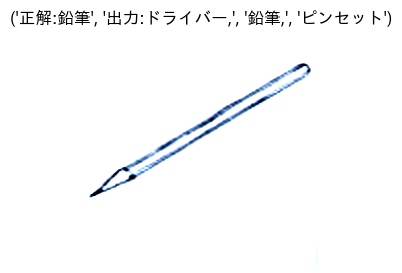

 84 Hit [ 84 117 158 165  92] 目尻 消しゴム しゃもじ りんご 目 [0.026 0.021 0.021 0.019 0.018]
 85 Hit [ 85  48 138  60  35] 芋 豆腐 御飯 レモン みかん [0.137 0.067 0.058 0.031 0.027]
 86 Hit [ 86 218  24 166  68] 吊り橋 吊橋 ガードレール 馬車 銭湯 [0.046 0.045 0.027 0.027 0.022]
 87 Hit [ 87 142 217  34 275] かき氷 菖蒲 鼻緒 ふくろう ピザ [0.231 0.057 0.049 0.047 0.043]
 88 Hit [ 88 122 107  91  87] 豹 牛 動物園 サイ かき氷 [0.071 0.051 0.046 0.034 0.028]
 89 Hit [ 89  98 202 171 176] サボテン 三輪車 お茶 蓮根 酒 [0.079 0.062 0.056 0.040 0.028]
 90 Hit [ 90 259   0  33 327] ピラミッド 箱 バス ヨット 弁当 [0.031 0.031 0.028 0.023 0.021]
 91 Hit [ 91 172  10  32 143] サイ 猫 兎 中指 ふくらはぎ [0.091 0.080 0.060 0.047 0.037]
 92 Hit [ 92 171 103 286  72] 目 蓮根 すりこ木 おにぎり バター [0.035 0.027 0.024 0.023 0.021]
 93 Hit [ 93  99 163 277  74] ひまわり 鶏 傘 にわとり 鳩 [0.145 0.065 0.055 0.047 0.041]
 94 Hit [ 94  32 102  18  11] はたき 中指 ドア 天井 ロープウエイ [0.026 0.026 0.026 0.022 0.020]
 95 Hit [ 95 147 170  87 128] 刺身 靴べら 便所 かき氷 手すり [0.046 0.039 0.030 0.027 0.027]
 96 Hit [ 96  18  80  87  36] 玄関 天井 廊下 かき氷 柱

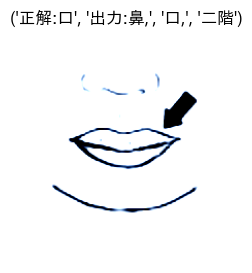

130 Hit [130 158  55  48 171] 大根 しゃもじ スプーン 豆腐 蓮根 [0.065 0.049 0.045 0.039 0.030]
131 Hit [131  62  19  12  68] 風車 乳母車 鍵 学校 銭湯 [0.059 0.057 0.034 0.031 0.024]
132 Hit [132 295 103 158 101] 鋏 はさみ すりこ木 しゃもじ アスパラガス [0.052 0.039 0.031 0.029 0.021]
133 Hit [133 177 174 150  90] 潜水艦 船 街灯 いかだ ピラミッド [0.039 0.037 0.029 0.029 0.022]
134 Hit [134 145 121  60  31] ステーキ タイヤキ ギョウザ レモン 天ぷら [0.139 0.084 0.038 0.038 0.035]
135 Hit [135   7 125 294 260] マッチ 風呂 畳 アルバム 切符 [0.069 0.037 0.029 0.021 0.020]
136 Hit [136   7 113 102 152] 二階 風呂 寺 ドア 鼻 [0.027 0.015 0.014 0.013 0.012]
137 Hit [137  98 115  43 306] 落花生 三輪車 ひょうたん くるみ 手紙 [0.139 0.044 0.034 0.033 0.029]
138 Hit [138 144  48  85  41] 御飯 桃 豆腐 芋 鍋 [0.075 0.051 0.048 0.045 0.039]
139 Hit [139 103  98  62  19] 自転車 すりこ木 三輪車 乳母車 鍵 [0.046 0.038 0.025 0.025 0.023]
140 Hit [140   7 170 136  33] 歩道橋 風呂 便所 二階 ヨット [0.030 0.024 0.022 0.021 0.020]
141 Hit [141 152  91 254  69] 鯨 鼻 サイ 裾野 ナマズ [0.060 0.028 0.022 0.022 0.019]
142 Hit [142  87 187  77 109] 菖蒲 かき氷 犀 チューリッ

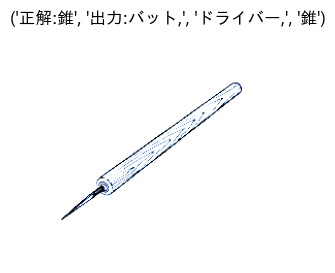

244 Hit [232 212 190 327 112] 升 鏡 毬藻 弁当 アイロン [0.102 0.078 0.063 0.029 0.023]
245 Hit [176 169 281 202 295] 酒 耳 指 お茶 はさみ [0.093 0.082 0.038 0.036 0.030]
246 Hit [233 183  27 112 290] 砂糖 急須 信号 アイロン 電話 [0.091 0.071 0.059 0.034 0.029]
247 Hit [234  93 207  46 199] 教会 ひまわり 舞妓 城 庇 [0.081 0.078 0.036 0.029 0.024]
248 Hit [235 233 308 295 184] 薪割り 砂糖 こけし はさみ 鉢巻 [0.122 0.097 0.086 0.046 0.044]
249 Hit [236 284  12 254 177] 雲 空 学校 裾野 船 [0.029 0.028 0.022 0.017 0.016]
250 Hit [237 180 112 185 317] 手袋 秤 アイロン 枕 かまぼこ [0.166 0.063 0.058 0.052 0.032]
251 Hit [238 243 248 227 323] 鼠 筏 河馬 蚊帳 キャベツ [0.125 0.068 0.048 0.044 0.042]
252 Hit [239 277 122 270 241] 駱駝 にわとり 牛 うさぎ 綱引き [0.051 0.043 0.033 0.028 0.028]
253 Hit [240 250 205 180  27] 黒子 御神輿 手 秤 信号 [0.058 0.056 0.037 0.036 0.034]
254 Hit [241 233  56 230 235] 綱引き 砂糖 朝顔 行司 薪割り [0.122 0.087 0.064 0.061 0.035]
255 Hit [242 262 158 202  48] コーヒー 紅茶 しゃもじ お茶 豆腐 [0.085 0.048 0.047 0.030 0.025]
256 Hit [243 237 302 295 221] 筏 手袋 デモ はさみ 菊人形 [0.094 0.061 0.042 0

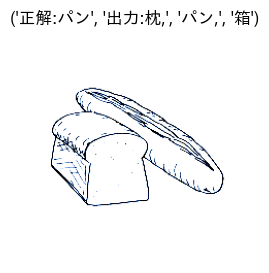

300 Hit [279 260 294  12  30] 切手 切符 アルバム 学校 コンセント [0.080 0.080 0.041 0.026 0.024]
301 Hit [280 253 259 102 260] テレビ 硯 箱 ドア 切符 [0.084 0.070 0.027 0.020 0.019]
302 Hit [281 306 297 210 158] 指 手紙 バット 鞘 しゃもじ [0.067 0.066 0.028 0.023 0.020]
303 Hit [282 320 193 194 252] カーテン 金魚 雨 鈴蘭 刷毛 [0.063 0.054 0.037 0.032 0.029]
304 Hit [165 261 264 323 252] りんご たこ たわし キャベツ 刷毛 [0.061 0.054 0.035 0.027 0.027]
305 Hit [283 185 225  76 246] 目薬 枕 灸 喉仏 踵 [0.040 0.040 0.038 0.036 0.025]
306 Hit [284  30 236   0 254] 空 コンセント 雲 バス 裾野 [0.039 0.031 0.030 0.025 0.022]
307 Hit [285 321 202 183 242] こま 灰皿 お茶 急須 コーヒー [0.122 0.105 0.049 0.029 0.024]
308 Hit [286 306 290 137  21] おにぎり 手紙 電話 落花生 電車 [0.076 0.050 0.048 0.043 0.043]
309 Hit [287 286 259 102  70] ポスト おにぎり 箱 ドア そば [0.058 0.031 0.027 0.027 0.024]
310 Hit [288  56  55 158 176] 虹 朝顔 スプーン しゃもじ 酒 [0.036 0.030 0.024 0.021 0.020]
311 Hit [ 27 259 318 301 285] 信号 箱 窓 ネクタイ こま [0.148 0.095 0.067 0.056 0.048]
312 Hit [289 184 207 291 176] エプロン 鉢巻 舞妓 あご 酒 [0.054 0.040 

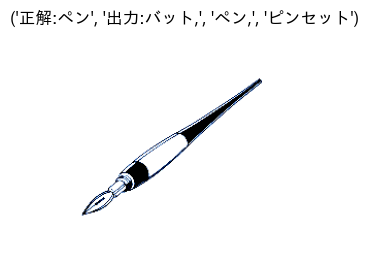

349 Hit [ 93  56  17 277 239] ひまわり 朝顔 あじさい にわとり 駱駝 [0.023 0.022 0.021 0.020 0.018]
350 Hit [316 125  13  27 117] ピアノ 畳 ちりとり 信号 消しゴム [0.092 0.054 0.045 0.035 0.030]
351 Hit [317 259  13 290 212] かまぼこ 箱 ちりとり 電話 鏡 [0.043 0.033 0.031 0.028 0.024]
352 Hit [318  27 188 301 112] 窓 信号 茶碗 ネクタイ アイロン [0.033 0.030 0.026 0.018 0.015]
353 Hit [319 260 294  75 167] そろばん 切符 アルバム 電卓 線路 [0.078 0.032 0.029 0.028 0.024]
354 Hit [320 195 199 252 318] 金魚 糸 庇 刷毛 窓 [0.090 0.087 0.034 0.032 0.029]
355 Hit [321 242 188 262 202] 灰皿 コーヒー 茶碗 紅茶 お茶 [0.062 0.058 0.038 0.030 0.027]
356 Hit [102 108 204   7 259] ドア 床の間 時計 風呂 箱 [0.038 0.038 0.031 0.028 0.028]
357 Hit [322 183 233 103 112] ふぐ 急須 砂糖 すりこ木 アイロン [0.253 0.049 0.028 0.028 0.022]
358 Hit [323 232 320 266  78] キャベツ 升 金魚 バナナ 白菜 [0.112 0.079 0.031 0.031 0.030]
359 Hit [324 259   7 250 135] 写真 箱 風呂 御神輿 マッチ [0.082 0.064 0.040 0.039 0.032]
360 Hit [325 176 225 233 283] なす 酒 灸 砂糖 目薬 [0.061 0.042 0.040 0.038 0.030]
361 Hit [326 234 199  68 250] アンテナ 教会 庇 銭湯 御神輿 [0.101

In [ ]:
#float_formatter = "{:.3f}".format
#np.set_printoptions(formatter={'float_kind':float_formatter})
# see https://note.nkmk.me/python-numpy-set-printoptions-float-formatter/
np.set_printoptions(formatter={'int': '{:3d}'.format, 'float_kind':'{:.3f}'.format})

def diagnose(no,
             name_dict=_num2id,
             num2word=_num2word,
             id2word=_id2word,
             filelist=_img_file_list,
             display=False,
             n_best=5):
    _id = name_dict[no]
    img_file = filelist[no]
    img = PILImage.open(img_file)

    label = num2word[no]

    # 画像の前処理と処理済み画像の表示
    size = 224
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    transform = ImageTransform(size, mean, std)
    img_transformed = transform(img, phase="val")  # torch.Size([3, 224, 224])

    # (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
    if display:
        img_transformed_ = img_transformed.numpy().transpose((1, 2, 0))
        img_transformed_ = np.clip(img_transformed_, 0, 1)
        plt.axis(False); plt.imshow(img_transformed_);plt.show()

    # 認識の実施
    inputs = transform(img, phase='val')
    inputs_ = inputs.unsqueeze_(0)
    out = net(inputs_)
    outnp = out.detach().numpy()
    ids = np.argsort( - outnp[0])
    sftmx = softmax(-outnp[0])

    print(f'{no:3d}', end=" ")
    OK = True
    if _id == ids[0]:
        print('Hit ', end="")
    else:
        print(colored('Miss', 'red'), end="")
        OK = False

    print(ids[:n_best], end=" ")
    for id_ in ids[:n_best]:
        print(id2word[id_], end=" ")
    print(- np.sort(-sftmx)[:n_best])
    if not OK:
        img_transformed_ = img_transformed.numpy().transpose((1, 2, 0))
        img_transformed_ = np.clip(img_transformed_, 0, 1)
        #plt.title('正解:{0}, 出力:{1},{2},{3}'.format(vocabs_i2w[id],
        #                                          vocabs_i2w[ids[0]],
        #                                          vocabs_i2w[ids[1]],
        #                                          vocabs_i2w[ids[2]]))
        plt.figure(figsize=(3,3))
        plt.title((f'正解:{num2word[no]}',
                  f'出力:{id2word[ids[0]]},', #,
                  f'{id2word[ids[1]]},', #) #,
                  f'{id2word[ids[2]]}'))
        # plt.title('正解:{0}, 出力:{1},{2},{3}'.format(num2word[no],
        #                                           id2word[ids[0]],
        #                                           id2word[ids[1]],
        #                                           id2word[ids[2]]))
        plt.axis(False);plt.imshow(img_transformed_);plt.show()


for i in range(len(_img_file_list)): # tlpa_sala)):
    diagnose(i, display=False, n_best=5)

In [ ]:
import ccap
#importlib.reload(ccap)
from ccap import imagenetDataset

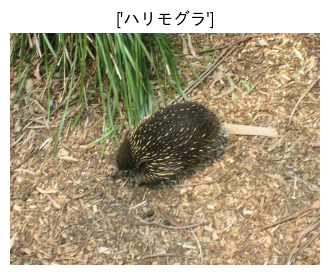

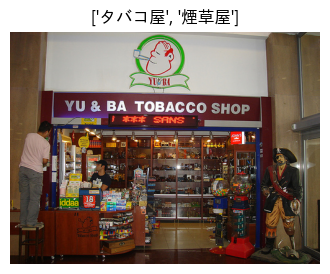

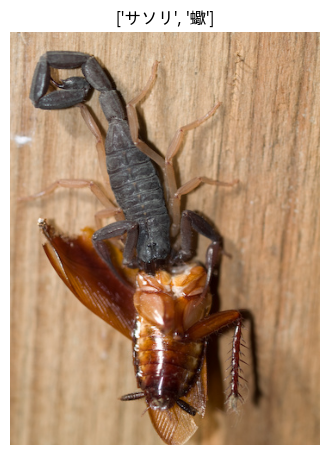

In [ ]:
imagenet = imagenetDataset()
for _ in range(3):
    num = np.random.choice(len(imagenet))
    imagenet.sample_and_show(num)

In [ ]:
# 出力結果からラベルを予測する後処理クラス
class ImageNetPredictor():
    """
    ImageNet データに対するモデルの出力からラベル出力

    Attributes:
        class_index : dictionary
        クラス index とラベル名 を対応させた辞書型変数
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        最大値を与える ImageNet ラベル名を返す

        Parameters:
            out : torch.Size([1, 1000])  Net からの出力

        Returns:
            predicted_labels: [str]
            最も予測確率が高いラベルの名前
        """
        outnp = out.detach().numpy()
        ids = np.argsort(- outnp)
        predicted_labels = [self.class_index[id] for id in ids[0]]

        return ids[0], predicted_labels, softmax(outnp)

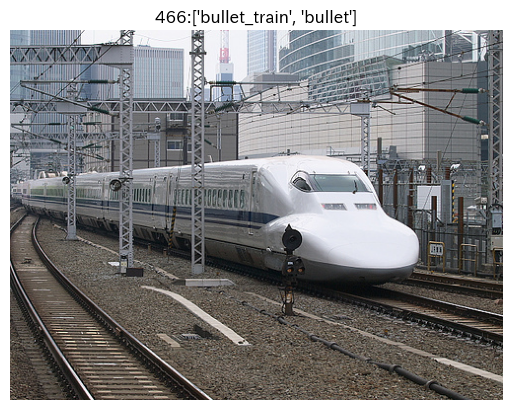

In [ ]:
# 下の no は 0 から 999 まで 1000 の ImageNet class に対応
no = np.random.choice(len(imagenet))
#print(f'no:{no}, ラベル:{imagenet.data[no]["label"]}')
img_file = imagenet.sample_image(no)
img = PILImage.open(img_file)
plt.title(f'{no}:{imagenet.data[no]["label"]}')
plt.axis(False); plt.imshow(img); plt.show()

In [ ]:
# 認識の実施
inputs = transform(img).unsqueeze_(0)  # torch.Size([1, 3, 224, 224])
out = net(inputs)  # torch.Size([1, 1000])

outnp = out.detach().numpy()
ids = np.argsort( - outnp)

n_best = 3
print(ids[0][:n_best])
for no in ids[0][:n_best]:
    print(imagenet(int(no))[1], end=" ")
    print(imagenet.getitem_from_wnid(imagenet(int(no))[1])['label'], end=" ")
    print(imagenet.getitem_from_wnid(imagenet(int(no))[1])['label_ja'], end=" ")
    print(imagenet.getitem_from_wnid(imagenet(int(no))[1])['definition'])


[265  14   9]
n02113624 ['toy_poodle'] [] the breed of very small poodles
n01537544 ['indigo_bunting', 'indigo_finch', 'indigo_bird', 'Passerina_cyanea'] ['ルリノジコ'] small deep blue North American bunting
n01518878 ['ostrich', 'Struthio_camelus'] ['オストリッチ', 'オーストリッチ', 'ダチョウ', '駝鳥', '鴕鳥'] fast-running African flightless bird with two-toed feet; largest living bird
